<center>

*******************************************************************************************

<font size="4">
Wavelet Coherence Transform<br>
</font>

##### 13 September 2025

##### Juan Ignacio Mendoza Garay
*******************************************************************************************

</center>

##### INFORMATION:

* The Wavelet Coherence Transform (WCT) measures the time-frequency relationship between two periodic signals at different time-scales.
>
* Dependencies:
    * [PyCWT](https://github.com/regeirk/pycwt)
    * [Matlab](https://se.mathworks.com/products/matlab.html)
    * [Matlab Engine for Python](https://se.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)
      
>
* Tested with:
    * Python 3.11
    * Matlab 2024b
    * Windows 11
>
* References:
    * Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. *Bulletin of the American Meteorological society, 79*(1), 61-78.
    * Krieger, S., & Freij, N. (2024). *PyCWT: Wavelet spectral analysis in Python*. https://github.com/regeirk/pycwt
    * [*PyCWT* documentation](https://pycwt.readthedocs.io)
    * Grinsted, A., Moore, J. C., & Jevrejeva, S. (2004). *Application of the cross wavelet transform and wavelet coherence to geophysical time series. Nonlinear processes in geophysics, 11*(5/6), 561-566.
    * [*wcoherence* documentation](https://se.mathworks.com/help/wavelet/ref/wcoherence.html)
>
* Instructions:
    * Ensure that the dependecies are installed.
    * Edit the values indicated with an arrow like this: <---
    * Run the program, close your eyes, and hope for the best.

*******************************************************************************************

In [1]:
import sys
import pycwt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

matlab_connected = False

***
### Define functions

In [2]:
def supersine(argdict):
    '''
    Produce a sine wave with optional variables for distortion.
    Arg:
        argdict (dict):
            Required values:
                argdict['frequency'] = f
                argdict['phase_shift'] = ps
                argdict['amplitude'] = a
                argdict['sampling_frequency'] = sf
                argdict['length'] = l
            Optional values:
                argdict['vertical_offset'] = vo
                argdict['irregularity'] = irr
                argdict['noise_strength'] = ns
                argdict['seed'] = s
    Returns:
        (numpy.ndarray): signal
    '''
    from scipy.interpolate import CubicSpline

    f = argdict.get('frequency')
    ps = argdict.get('phase_shift')
    amp = argdict.get('amplitude')
    fps = argdict.get('sampling_frequency')
    l = argdict.get('length')
    v_offset = argdict.get('vertical_offset',0)
    irregularity = argdict.get('irregularity',0)
    noise_strength = argdict.get('noise_strength',0)
    noise_strength = noise_strength
    seed = argdict.get('seed',None)

    rangen = np.random.default_rng(seed=seed)
    t = np.arange(0, l)/fps
    y = np.sin(2*np.pi*f*t + ps)
    if irregularity:
        if irregularity >= 1:
            y = np.zeros(l)
        else:
            n_ran = int(np.ceil((l-2) * (1-irregularity)**2))
            if n_ran < 1: n_ran = 1
            ran_idx = np.sort(rangen.choice(np.arange(1,l), size=n_ran, replace=False))
            ip_x = np.insert(ran_idx, [0,n_ran], [0,l])
            ip_y = y[ran_idx]
            ip_y = ip_y - ip_y * rangen.random(size=ip_y.shape[0]) * irregularity**2
            ip_y = np.insert(ip_y, [0,n_ran], [0,0])
            ipf = CubicSpline(ip_x,ip_y)
            y = ipf(np.arange(l))
    noiz = rangen.uniform(-0.9,0.9,l)
    y = (y - (y * noiz * noise_strength ))
    y = (y * amp) / (np.max( [ abs(y.min()) , y.max() ] ) * 2)
    y = y + v_offset
    return y

In [3]:
def testdata(*args,**kwargs):
    '''
    Synthetic data for testing functions that measure synchronisation.
    Arguments can be the same keywords for function 'init_testdatavars,
    or a dictionary resulting from that function.
    If no arguments are given, default data will be produced with the function 'init_testdatavars'.
    Args:
        See documentation for syncoord.utils.init_testdatavars
    Returns:
        (numpy.ndarray): N-D array with dimensions [points,axes,frames]
    '''
    if args:
        kwargs = args[0]

    if not kwargs:
        kwargs = init_testdatavars()

    if kwargs:
        fps = kwargs.get('fps')
        durations_sections = kwargs.get('durations_sections')
        total_length = kwargs.get('total_duration')*fps
        n_points = kwargs.get('n_points')
        n_axes = kwargs.get('n_axes')
        seed = kwargs.get('seed',None)
        point_vars = kwargs.get('point_vars') # dim = [sections,points,axes,vars]
        # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength

    test_data = np.empty((n_points,n_axes,total_length)) # dim = [points,axes,frames]
    wavargs = {}
    wavargs['sampling_frequency'] = fps
    wavargs['seed'] = seed
    i_start_section = 0
    for i_s,s in enumerate(point_vars):
        n_frames = durations_sections[i_s] * fps
        i_end_section = i_start_section + n_frames
        for i_p,p in enumerate(s):
            for i_ax,ax in enumerate(p):
                wavargs['frequency'] = ax[0]
                wavargs['phase_shift'] = ax[1]
                wavargs['amplitude'] = ax[2]
                wavargs['length'] = n_frames
                wavargs['vertical_offset'] = ax[3]
                wavargs['irregularity']  = ax[4]
                wavargs['noise_strength'] = ax[5]
                if wavargs['seed'] is not None: wavargs['seed'] += 1
                test_data[i_p,i_ax,i_start_section:i_end_section] = supersine(wavargs)
        i_start_section = i_end_section
    return test_data

In [4]:
def vis_wct(m, title):

    if m.shape[0] == 1:
        plt.figure(figsize=(10,2))
        plt.plot(m[0])
        plt.xlim((0,m.shape[1]))
        plt.xlabel('time (frames)')
        plt.title(title + '\nmethod: ' + wct_method)
    else:
        plt.figure(figsize=(10,4))
        plt.subplot(2,1,1)
        plt.imshow(m, aspect='auto')
        yticks_loc,_ = plt.yticks()
        yticks_loc_new = yticks_loc
        yticks_loc_new = [int(i) for i in yticks_loc_new if ((i >= 0) and (i < m.shape[0]))]
        yticks_lbl = [round(freq_out[i],1) for i in yticks_loc_new]
        plt.yticks(yticks_loc_new,yticks_lbl)
        plt.ylabel('frequency $(Hz)$')
        plt.xlim((0,m.shape[1]))
        plt.xlabel('time (frames)')
        plt.title(title + '\nmethod: ' + wct_method)

        m_mean = np.nanmean(m,axis=0)
        plt.subplot(2,1,2)
        plt.plot(m_mean)
        plt.xlim((0,m.shape[1]))
        plt.xlabel('time (frames)')
        plt.title('Mean '+title)
        plt.tight_layout()

***
### Generate synthetic data

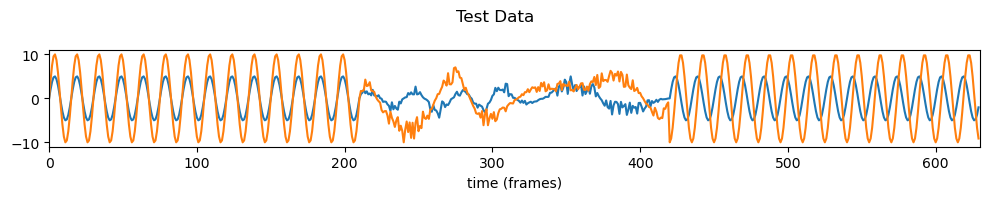

In [5]:
bl_f = 2  # <--- baseline frequency (Hz)
seed = 1  # <--- pseudorandom generator's seed

testdata_vars = { 'fps':30,'durations_sections':[7,7,7], 'n_points':2,'n_axes':1 }
testdata_vars['total_duration'] = sum(testdata_vars['durations_sections'])
testdata_vars['point_vars'] = np.empty(( len(testdata_vars['durations_sections']),
                                         testdata_vars['n_points'], testdata_vars['n_axes'],6 ))

# vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength
# section 0:
testdata_vars['point_vars'][0,0,0] = 1, 0,   10, 0, 0, 0
testdata_vars['point_vars'][0,1,0] = 1, 0,   20, 0, 0, 0
# section 1:
testdata_vars['point_vars'][1,0,0] = 1, 0.2, 10, 0, 0.72, 0.8
testdata_vars['point_vars'][1,1,0] = 1, 0.7, 20, 0, 0.78, 0.5
# section 2:
testdata_vars['point_vars'][2,0,0] = 1, 0,         10, 0, 0, 0
testdata_vars['point_vars'][2,1,0] = 1, 3*np.pi/2, 20, 0, 0, 0

testdata_vars['point_vars'][[0,2],...,0] = bl_f

test_data_0 = np.squeeze( testdata(**testdata_vars) )

plt.figure(figsize=(10,2))
for s in test_data_0:
    plt.plot(s)
    plt.xlim((0,len(s)))
plt.xlabel('time (frames)')
plt.suptitle('Test Data')
plt.tight_layout();

Sections:
>0: all in synchrony, different amplitude\
1: random oscillation\
2: constant phase difference, different amplitude

***
### Wavelet Coherence Transform

n scales =  40
freq. scales (Hz) = 
 [10.          9.43874313  8.90898718  8.40896415  7.93700526  7.49153538
  7.07106781  6.67419927  6.29960525  5.94603558  5.61231024  5.29731547
  5.          4.71937156  4.45449359  4.20448208  3.96850263  3.74576769
  3.53553391  3.33709964  3.14980262  2.97301779  2.80615512  2.64865774
  2.5         2.35968578  2.2272468   2.10224104  1.98425131  1.87288385
  1.76776695  1.66854982  1.57490131  1.48650889  1.40307756  1.32432887
  1.25        1.17984289  1.1136234   1.05112052]


C:\Users\juigmend\AppData\Local\Temp\ipykernel_5748\2265011976.py:23: RuntimeWarning: Mean of empty slice
  m_mean = np.nanmean(m,axis=0)


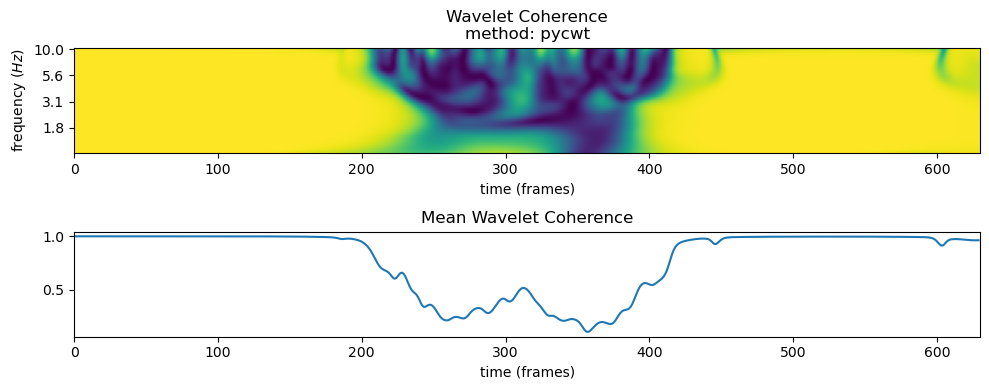

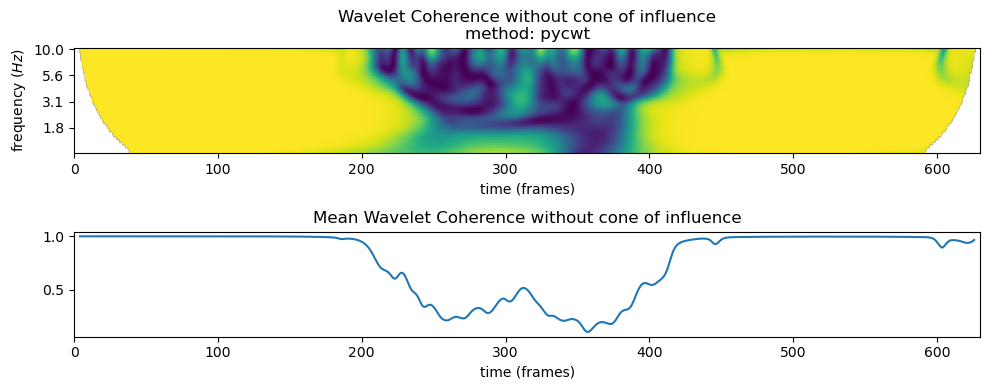

In [6]:
wct_freq = [1,10]     # <--- frequency (Hz): float or [minimum, maximum]
# wct_freq = 2           # <--- frequency (Hz): float or [minimum, maximum]

wct_method = 'pycwt' # <--- 'pycwt' or 'matlab'
# wct_method = 'matlab' # <--- 'pycwt' or 'matlab'

if wct_method == 'pycwt':

    if isinstance(wct_freq,list): minmaxf = wct_freq
    elif isinstance(wct_freq,(int,float)): minmaxf = [wct_freq, wct_freq]
    else: raise Exception('wrong type for wct_freq')

    dt = 1/testdata_vars['fps']
    flambda = pycwt.Morlet().flambda()
    s0 = 1/(flambda*minmaxf[1])
    dj=1/12
    J = np.floor(np.log2( minmaxf[1]/minmaxf[0] ) / dj)

    WCT, _, coi, freq_out, _ = pycwt.wct( test_data_0[0], test_data_0[1],
                                          dt, dj=dj, s0=s0, J=J,
                                          wavelet='morlet', normalize=False, sig=False )

elif wct_method == 'matlab':

    if matlab_connected: print('Already connected to Matlab.')
    else: # allow to run sc.ptdata.gxwt multiple times without reconnecting to Matlab
        import matlab.engine
        print('Connecting to Matlab...')
        matlabeng = matlab.engine.start_matlab()
        print('...connected to Matlab version',matlabeng.version())
        matlab_connected = True

    remove_lo = False
    if isinstance(wct_freq,list): freq_lim = matlab.double(wct_freq)
    elif isinstance(wct_freq,(int,float)):
        freq_lim = matlab.double([wct_freq-0.2,wct_freq])
        remove_lo = True
    else: raise Exception('wrong type for wct_freq')

    WCT, _, freq_out, coi = matlabeng.wcoherence( test_data_0[0], test_data_0[1],
                                                  testdata_vars['fps'],'FrequencyLimits', freq_lim,
                                                  'VoicesPerOctave', 12, nargout=4 )

    WCT = np.array(WCT)
    freq_out = np.array(freq_out).T[0]
    coi = 1/np.array(coi)[0]
    if remove_lo:
        WCT = np.delete(WCT,0,axis=0)
        freq_out = np.delete(freq_out,-1)

else: raise Exception('wrong wct_method')

print('n scales = ',len(freq_out))
if len(freq_out) > 5: nln = '\n'
else: nln = ''
print('freq. scales (Hz) =',nln,freq_out)

vis_wct(WCT, "Wavelet Coherence")

period = 1/freq_out
coi[ coi > 1/freq_out[-1] ] = np.nan
WCT_c = WCT.copy()
for i,t in enumerate(coi):
    if np.isnan(t): break
    row = np.argmin(abs(t-period))
    WCT_c[row:, (i,-i)] = np.nan

vis_wct(WCT_c, "Wavelet Coherence without cone of influence")